In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

from networks.efficient_v2_lrl_pro_224 import ConEfficientNet, LinearClassifier
from dataset_cer_weekly import DatasetPrepare_CER, fit_global_hour_stats

# ==========================================
# 1. THIẾT LẬP SEED
# ==========================================
def init_seed(seed: int):
    torch.cuda.cudnn_enabled = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

SEED = 199
init_seed(SEED)
print(f"Seed set to: {SEED}")

# ==========================================
# 2. CẤU HÌNH ĐƯỜNG DẪN (CHECK KỸ)
# ==========================================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_DIR = '../data/CER_ETD/prepared_etd_weekly_3' 
MODEL_DIR = '../save/UniCon_v2_ETD_LRL_Binary_2' 
# Checkpoint epoch cuối cùng
ENC_PATH = os.path.join(MODEL_DIR, 'ckpt_epoch_53.pth')
CLS_PATH = os.path.join(MODEL_DIR, 'ckpt_class_53.pth')
print(f"Device: {DEVICE}")

Seed set to: 199
Device: cuda


In [15]:
print("Loading train stats...")
train_npz = np.load(os.path.join(DATA_DIR, 'train.npz'), allow_pickle=True)
X_train = train_npz['data'].astype(np.float32)

# Lấy mẫu Benign để tính stats
if 'label' in train_npz: t_train = train_npz['label']
else: t_train = train_npz['atk']

X_train_benign = X_train[t_train == 0]
mu_val, sd_val = fit_global_hour_stats(X_train_benign)
print(f"Global Stats -> Mean: {mu_val:.4f}, Std: {sd_val:.4f}")

test_ds = DatasetPrepare_CER(
    root_dir=DATA_DIR,
    is_train=False,       # Load val.npz
    mu_hour=mu_val,       # Dùng stats của tập train
    sd_hour=sd_val,
    encoder='heatmap',    # Dùng encoder tạo ảnh 2D
    transform=None,       # Không augment khi test
    target_size=(224, 224)
)

test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)
print(f"Test Set Size: {len(test_ds)}")

Loading train stats...
Global Stats -> Mean: 0.1625, Std: 0.1360
Test Set Size: 10005


In [21]:
model = ConEfficientNet(
    embedding_dim=1792, 
    feat_dim=128, 
    head='mlp',
    pretrained=False,
    num_prototypes=2,
    target_size=(224, 224)
).to(DEVICE)

classifier = LinearClassifier(input_dim=128, num_classes=2).to(DEVICE)

# 2. Load Weights
if os.path.exists(ENC_PATH) and os.path.exists(CLS_PATH):
    # Load Encoder
    ckpt_enc = torch.load(ENC_PATH, map_location=DEVICE, weights_only=False)
    state_dict_enc = ckpt_enc['model'] if 'model' in ckpt_enc else ckpt_enc
    model.load_state_dict(state_dict_enc, strict=False)
    print("Encoder weights loaded successfully.")

    # Load Classifier
    ckpt_cls = torch.load(CLS_PATH, map_location=DEVICE, weights_only=False)
    state_dict_cls = ckpt_cls['model'] if 'model' in ckpt_cls else ckpt_cls
    classifier.load_state_dict(state_dict_cls, strict=False)
    print("Classifier weights loaded successfully.")
else:
    print("ERROR: Checkpoint files not found!")

model.eval()
classifier.eval()

Encoder weights loaded successfully.
Classifier weights loaded successfully.


LinearClassifier(
  (net): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [22]:
all_true = []
all_probs = []

print("Running inference...")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Forward
        feats = model(images)
        logits = classifier(feats)
        
        # Lấy xác suất lớp 1 (Attack)
        probs = F.softmax(logits, dim=1)[:, 1]
        
        all_true.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

y_true = np.array(all_true)
y_probs = np.array(all_probs)

# --- AUTO THRESHOLD SEARCH ---
best_f1 = 0
best_thresh = 0.5

# Quét ngưỡng để tìm F1 cao nhất
for thr in np.arange(0.1, 0.99, 0.01):
    preds = (y_probs > thr).astype(int)
    score = f1_score(y_true, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = thr

print(f"\nOptimal Threshold: {best_thresh:.2f}")

# Tính metrics với ngưỡng tối ưu
y_pred = (y_probs > best_thresh).astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_probs)

print(f"Accuracy:  {acc:.4f}")
print(f"F1-Score:  {best_f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"AUC:       {auc_score:.4f}")

Running inference...

Optimal Threshold: 0.10
Accuracy:  0.9988
F1-Score:  0.9978
Precision: 1.0000
Recall:    0.9955
AUC:       0.9985


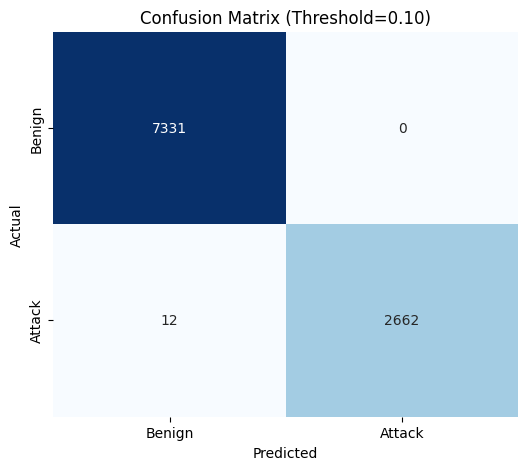

In [25]:
# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.title(f'Confusion Matrix (Threshold={best_thresh:.2f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
def adapter_1d_to_2d(x_1d, target_size=(224, 224)):
    """Adapter: 1D (168) -> Heatmap (224x224)"""
    B, L = x_1d.shape
    x_flat = x_1d.view(B, 168)
    x_grid = x_flat.view(B, 1, 7, 24) # 7 ngày, 24 giờ
    x_img = F.interpolate(x_grid, size=target_size, mode='nearest') 
    x_rgb = x_img.repeat(1, 3, 1, 1) 
    return x_rgb

def visualize_model_input(sample_idx):
    x_raw_np = test_ds.X[sample_idx]
    label = test_ds.atk[sample_idx] if hasattr(test_ds, 'atk') else test_ds.y[sample_idx]

    x_log = np.log1p(np.clip(x_raw_np, 0.0, None))
    x_norm = (x_log - np.log1p(mu_val)) / (np.log1p(sd_val) + 1e-6)
    
    x_tensor = torch.tensor(x_norm).float().unsqueeze(0).to(DEVICE) # [1, 168]
    
    with torch.no_grad():
        if hasattr(model, '_adapter_1d_to_2d'):
            img_tensor = model._adapter_1d_to_2d(x_tensor) 
        else:
            img_tensor = adapter_1d_to_2d(x_tensor)
            
    img_np = img_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img_vis = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-6)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(x_raw_np, color='blue' if label==0 else 'red', linewidth=1.5)
    title_lbl = "BENIGN" if label == 0 else f"ATTACK (Type {label})"
    axes[0].set_title(f"Raw 1D Input (168h) - {title_lbl}")
    axes[0].set_xlabel("Hour (0-167)")
    axes[0].set_ylabel("KWh")
    axes[0].grid(True, alpha=0.3)
    for day in range(1, 7):
        axes[0].axvline(x=day*24, color='gray', linestyle=':', alpha=0.5)
    
    im = axes[1].imshow(img_vis, aspect='auto', cmap='magma') 
    axes[1].set_title(f"Model View: Calendar Heatmap (224x224)\n(Resized from 7 days x 24 hours)")
    axes[1].axis('off')
    
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

==================== VISUALIZING ALL CLASSES ====================

>>> BENIGN (Bình thường):


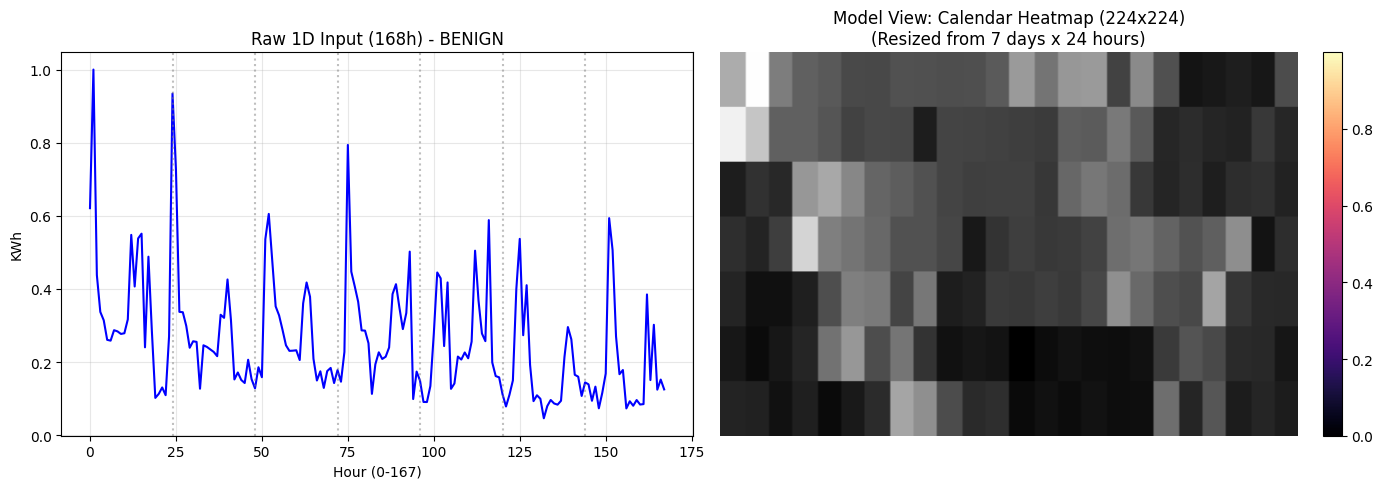


>>> ATTACK H1 (Scale Down - Giảm biên độ):


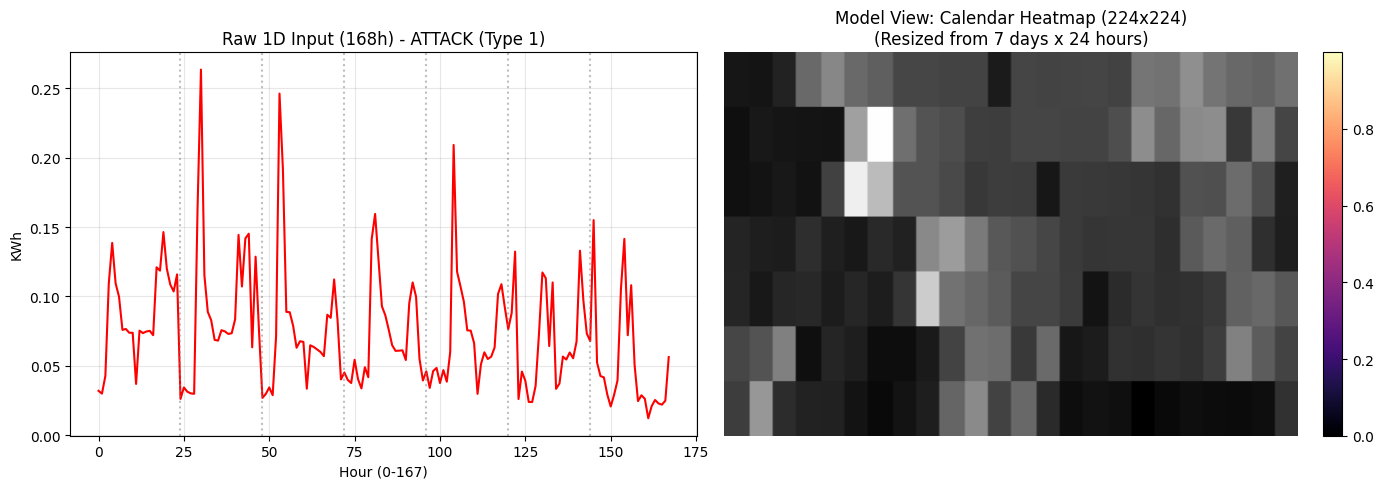


>>> ATTACK H2 (Random Scale - Gai góc/Nhiễu):


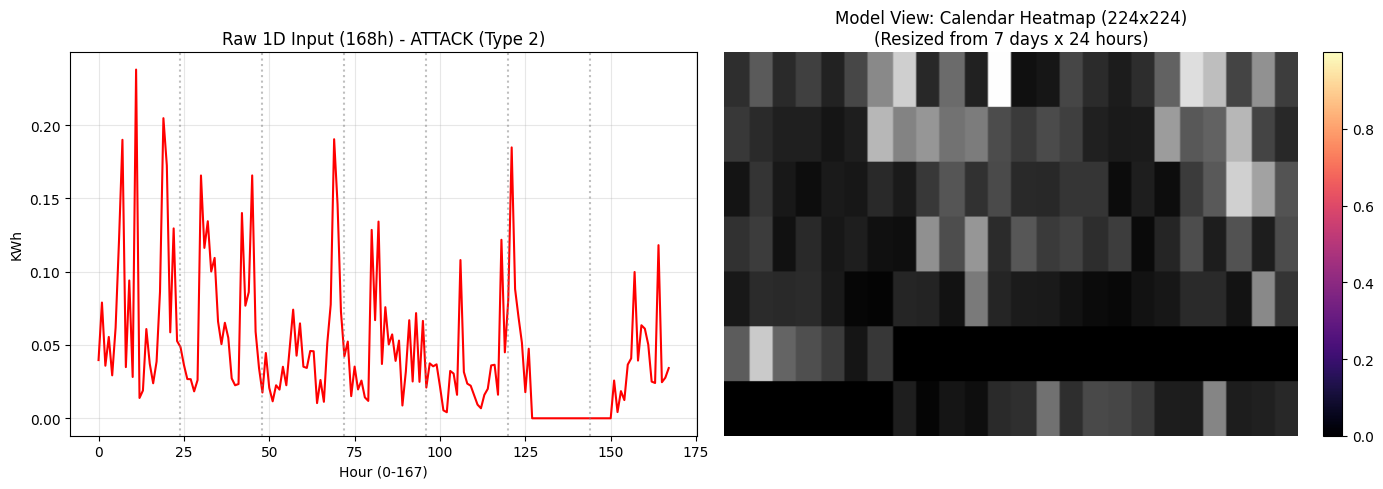


>>> ATTACK H3 (Mean Flat - Đường thẳng phẳng):


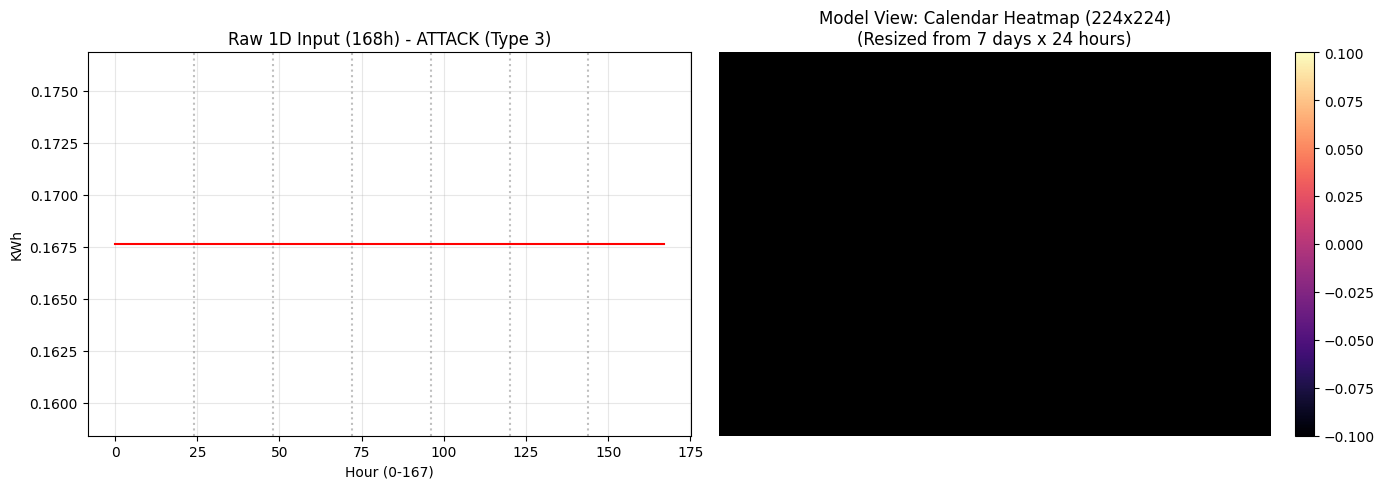


>>> ATTACK H4 (Mean Scaled - Đường thẳng thấp):


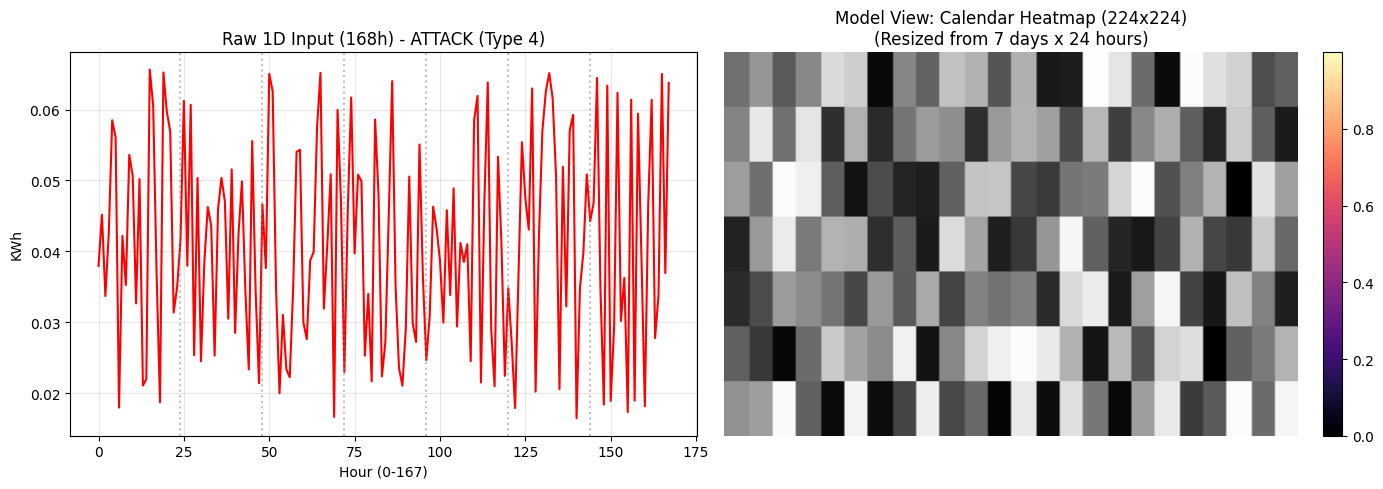


>>> ATTACK H5 (Zero Interval - Mất tín hiệu):


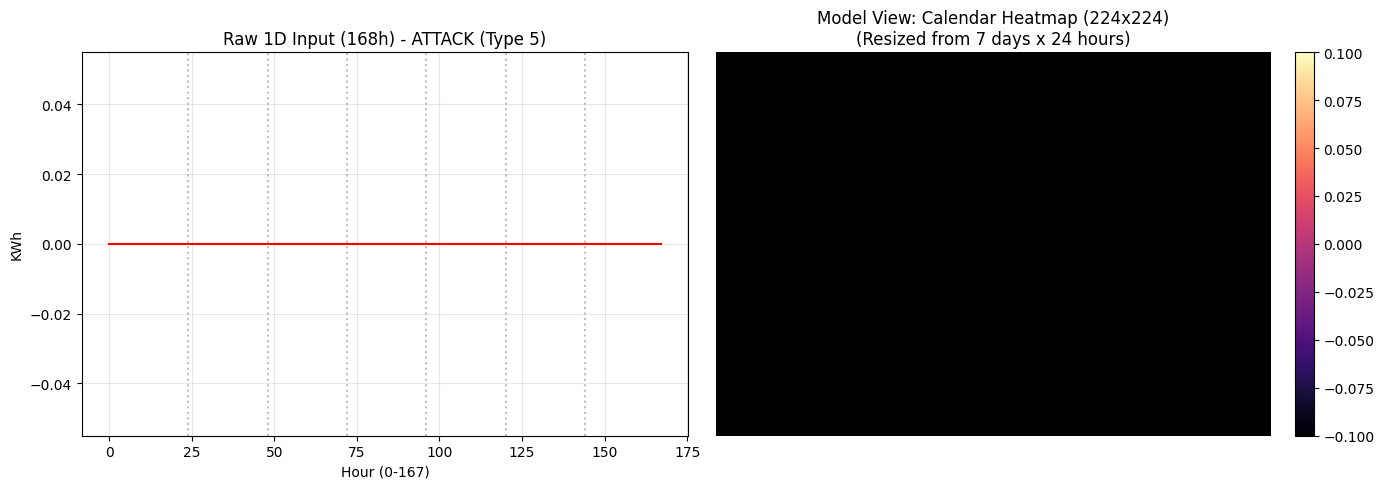


>>> ATTACK H6 (Reverse Day - Đảo ngược):


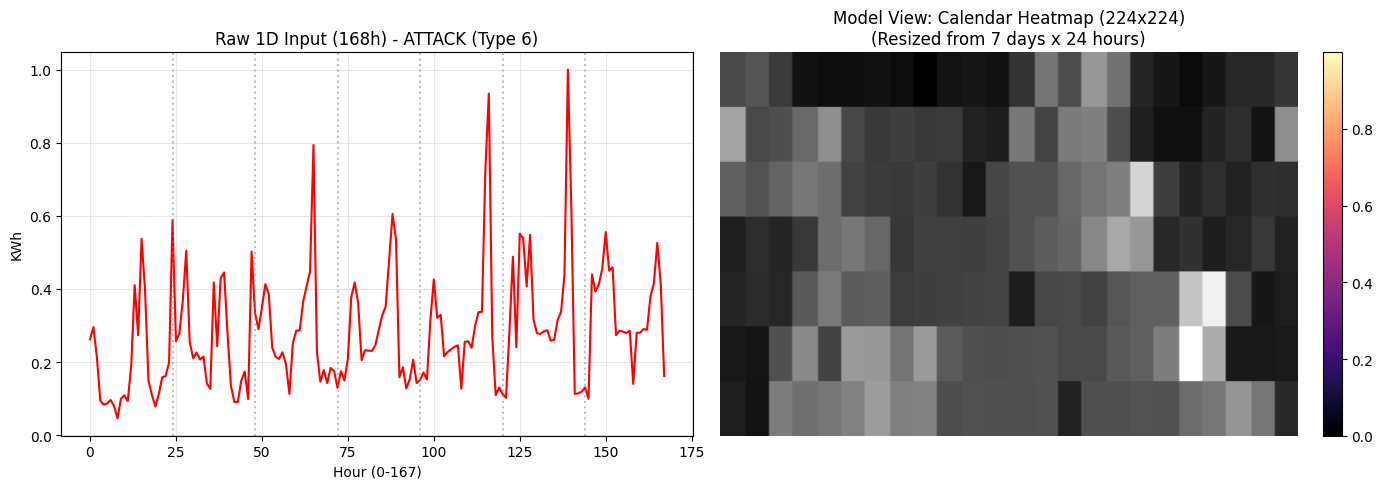

In [28]:
class_descriptions = {
    0: "BENIGN (Bình thường)",
    1: "ATTACK H1 (Scale Down - Giảm biên độ)",
    2: "ATTACK H2 (Random Scale - Gai góc/Nhiễu)",
    3: "ATTACK H3 (Mean Flat - Đường thẳng phẳng)",
    4: "ATTACK H4 (Mean Scaled - Đường thẳng thấp)",
    5: "ATTACK H5 (Zero Interval - Mất tín hiệu)",
    6: "ATTACK H6 (Reverse Day - Đảo ngược)"
}

print(f"{'='*20} VISUALIZING ALL CLASSES {'='*20}")

for label_id in range(7):
    idxs = np.where(test_ds.atk == label_id)[0]
    
    if len(idxs) > 0:
        print(f"\n>>> {class_descriptions[label_id]}:")
        random_idx = np.random.choice(idxs)
        visualize_model_input(random_idx)
    else:
        print(f"\n>>> {class_descriptions[label_id]}: KHÔNG TÌM THẤY mẫu nào trong tập Test.")